In [20]:
!pip install tensorflow


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import warnings
warnings.filterwarnings('ignore')


load nd clean the data set

In [6]:
df = pd.read_csv("TCS_stock_history.csv")  # Use your main historical dataset
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')

# Check for nulls & types
df = df.dropna()
df.dtypes


Date            datetime64[ns]
Open                   float64
High                   float64
Low                    float64
Close                  float64
Volume                   int64
Dividends              float64
Stock Splits           float64
dtype: object

eda

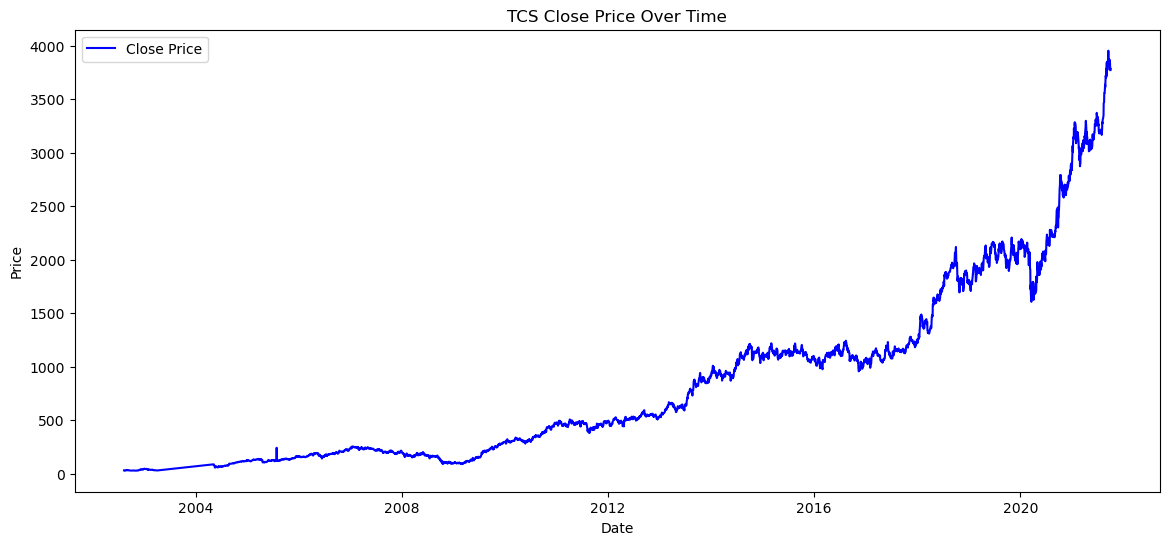

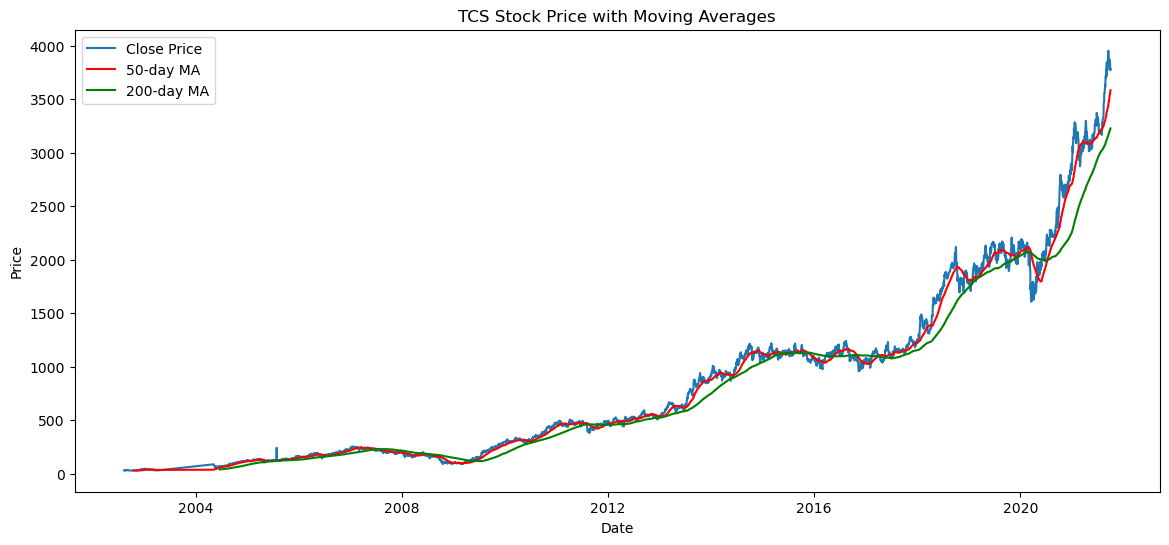

In [7]:
# Close price over time
plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['Close'], label='Close Price', color='blue')
plt.title("TCS Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

# Moving averages
df['MA50'] = df['Close'].rolling(window=50).mean()
df['MA200'] = df['Close'].rolling(window=200).mean()

plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['Close'], label='Close Price')
plt.plot(df['Date'], df['MA50'], label='50-day MA', color='red')
plt.plot(df['Date'], df['MA200'], label='200-day MA', color='green')
plt.title("TCS Stock Price with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


feature engineering

In [8]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Day_of_Week'] = df['Date'].dt.dayofweek
df['Prev_Close'] = df['Close'].shift(1)
df = df.dropna()


In [17]:
df.head()


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,MA50,MA200,Year,Month,Day,Day_of_Week,Prev_Close
199,2004-06-21,66.919920,68.407029,64.540547,65.451401,49328,0.0,0.0,53.539858,38.361673,2004,6,21,0,66.157806
200,2004-06-22,65.432855,65.618744,63.573967,63.927155,20064,0.0,0.0,54.208315,38.533714,2004,6,22,1,65.451401
201,2004-06-23,64.596334,65.061056,61.584935,62.681683,22912,0.0,0.0,54.837176,38.701525,2004,6,23,2,63.927155
202,2004-06-24,63.192893,64.317518,61.919554,63.722672,21592,0.0,0.0,55.496152,38.884579,2004,6,24,3,62.681683
203,2004-06-25,63.202185,65.061073,63.202185,63.722672,60280,0.0,0.0,56.147134,39.067632,2004,6,25,4,63.722672


linear regression model

In [9]:
X = df[['Open', 'High', 'Low', 'Volume', 'Prev_Close', 'Day_of_Week', 'Month']]
y = df['Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

print("Linear Regression MSE:", mean_squared_error(y_test, y_pred_lr))
print("Linear Regression R²:", r2_score(y_test, y_pred_lr))


Linear Regression MSE: 39.049929985801676
Linear Regression R²: 0.9999438356582184


 LSTM Time Series Forecasting

In [10]:
# Prepare data
close_prices = df['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler()
close_scaled = scaler.fit_transform(close_prices)

X_lstm = []
y_lstm = []

for i in range(1, len(close_scaled)):
    X_lstm.append(close_scaled[i-1])
    y_lstm.append(close_scaled[i])

X_lstm = np.array(X_lstm).reshape(-1, 1, 1)
y_lstm = np.array(y_lstm)

# Build Model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(1,1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_lstm, y_lstm, epochs=20, batch_size=16, verbose=1)

# Predict
predicted_scaled = model.predict(X_lstm)
predicted_prices = scaler.inverse_transform(predicted_scaled)


Epoch 1/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0535
Epoch 2/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0063
Epoch 3/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.0972e-04
Epoch 4/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.8294e-04
Epoch 5/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.4901e-04
Epoch 6/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.2533e-04
Epoch 7/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 9.7800e-05
Epoch 8/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 7.9449e-05
Epoch 9/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 6.1934e-05
Epoch 10/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 5.0063e-05
Epoch 11/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 3.8645e-05
Epoch 12/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3.5378e-05
Epoch 13/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 2.7244e-05
Epoch 14/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2.9822e-05
Epoch 15/

In [ ]:
Plot LSTM Predictions

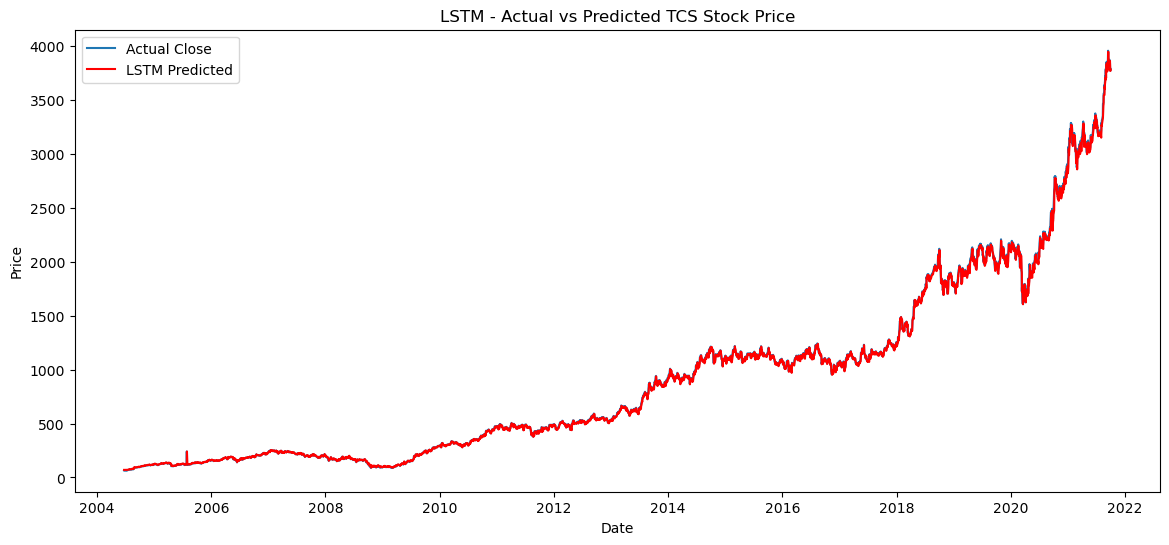

In [11]:
plt.figure(figsize=(14,6))
plt.plot(df['Date'][1:], df['Close'][1:], label='Actual Close')
plt.plot(df['Date'][1:], predicted_prices.flatten(), label='LSTM Predicted', color='red')
plt.title('LSTM - Actual vs Predicted TCS Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


Save Model and output

In [16]:
# Save the model in the recommended Keras format
model.save("TCS_LSTM_model.keras")
print("✅ Model saved as TCS_LSTM_model.keras")

# Save predictions as CSV
pred_df = pd.DataFrame({
    'Date': df['Date'][1:].reset_index(drop=True),
    'Actual_Close': df['Close'][1:].reset_index(drop=True),
    'Predicted_Close': predicted_prices.flatten()
})
pred_df.to_csv("TCS_LSTM_Predictions.csv", index=False)
print("✅ Predictions saved as TCS_LSTM_Predictions.csv")

# Confirm saved files
import os
print("📂 Files in current directory:", os.listdir())


✅ Model saved as TCS_LSTM_model.keras
✅ Predictions saved as TCS_LSTM_Predictions.csv
📂 Files in current directory: ['.ipynb_checkpoints', 'TCS Stock Data - Live and Latest.pdf', 'TCS_LSTM_model.h5', 'TCS_LSTM_model.keras', 'TCS_LSTM_Predictions.csv', 'TCS_stock_action.csv', 'TCS_stock_history.csv', 'TCS_stock_info (1).csv', 'Untitled.ipynb']


In [18]:
print("✅ Saved model and predictions.")
print("Files in directory:", os.listdir())


✅ Saved model and predictions.
Files in directory: ['.ipynb_checkpoints', 'TCS Stock Data - Live and Latest.pdf', 'TCS_LSTM_model.h5', 'TCS_LSTM_model.keras', 'TCS_LSTM_Predictions.csv', 'TCS_stock_action.csv', 'TCS_stock_history.csv', 'TCS_stock_info (1).csv', 'Untitled.ipynb']


In [19]:
# Save the model
model.save("TCS_LSTM_model.keras")
print("✅ Model saved.")

# Load the model
from tensorflow.keras.models import load_model
model = load_model("TCS_LSTM_model.keras")
model.summary()


✅ Model saved.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,904 (81.66 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,453 (40.84 KB)

✅ 🔮 Predict Next Stock Price Using the Saved Model

In [21]:
# 📍 Load the saved model
from tensorflow.keras.models import load_model
model = load_model("TCS_LSTM_model.keras")

# 📍 Prepare the most recent close price for prediction
last_close_price = df['Close'].values[-1]
scaled_input = scaler.transform([[last_close_price]])
reshaped_input = scaled_input.reshape(1, 1, 1)

# 📍 Make prediction
predicted_scaled = model.predict(reshaped_input)
predicted_price = scaler.inverse_transform(predicted_scaled)

# 📍 Output the prediction
print("📈 Next Day Predicted Close Price (TCS): ₹", round(predicted_price.flatten()[0], 2))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 925ms/step
📈 Next Day Predicted Close Price (TCS): ₹ 3760.63


🧠 What This Does:
Uses the last known stock price as input

Scales it (just like during training)

Feeds it into the LSTM model

Outputs the next predicted close price



In [22]:
from datetime import timedelta

next_day = df['Date'].max() + timedelta(days=1)
print(f"📅 Predicted Close Price for {next_day.date()}: ₹{round(predicted_price.flatten()[0], 2)}")


📅 Predicted Close Price for 2021-10-01: ₹3760.6298828125
